In [22]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
from clustering import cluster, cluster_net

In [24]:
# US rate
US_rate = pd.read_csv(r"financial_data/USD_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['3M']

# HFRX
hfrx_all = pd.read_csv(r"financial_data/hfrx_daily_index_data.csv", index_col=0, parse_dates=True, dayfirst=True).ffill()

# BNP
bnp = pd.read_csv(r"financial_data/bnp_data.csv", index_col=0, parse_dates=True, dayfirst=True)
risk_premia = pd.read_pickle("financial_data/risk_premia_ER_FX_USD.pkl")


In [25]:
df_info = pd.read_csv(r"financial_data/bnp_info.csv", index_col=0)
df_info.T

Ticker,BNPIDRXA,BNPIF3AX,BNPIF3XM,BPFXSTGU,BNPICCE3,BNPIVMRU,BPCURVW4,BNPIVCXA,BNPIAIRT,BPFXGGUR,...,SPGSICP,SPGSIZP,SPGSIKP,SPGSILP,SPGSGCP,SPGSSIP,BNPXCEB5,BNPXCEX5,BNPXCIG5,BNPXCHY5
Asset Class,Commodity,Commodity,Commodity,FX,Equity,Equity,MM,Commodity,Equity,FX,...,Commodity,Commodity,Commodity,Commodity,Commodity,Commodity,Credit,Credit,Credit,Credit
Style,Carry,Carry,Momentum,Value,Carry,Reversal,Carry,Volatility,Volatility,Carry,...,Classic,Classic,Classic,Classic,Classic,Classic,Classic,Classic,Classic,Classic


In [26]:
hfrx_info = pd.read_csv(r"financial_data/hfrx_index_names.csv", index_col=0)
hfrx_info.T

Name,HFRXAR,HFRXDS,HFRXMA,HFRXSS,HFRXEMN,HFRXEHG,HFRXEHV,HFRXEMC,HFRXEW,HFRXEH,...,HFRXM,HFRXSDV,HFRXMD,HFRXMLP,HFRXMREG,HFRXNA,HFRXRVA,HFRXCA,HFRXRVMS,NEIXCTAT
Full Name,HFRX Absolute Return Index,HFRX ED: Distressed Restructuring Index,HFRX ED: Merger Arbitrage Index,HFRX ED: Special Situations Index,HFRX EH: Equity Market Neutral Index,HFRX EH: Fundamental Growth Index,HFRX EH: Fundamental Value Index,HFRX Emerging Markets Composite Index,HFRX Equal Weighted Strategies Index,HFRX Equity Hedge Index,...,HFRX Macro/CTA Index,HFRX Macro: Systematic Diversified CTA Index,HFRX Market Directional Index,HFRX MLP Index,HFRX Multi-Region Index,HFRX North America Index,HFRX Relative Value Arbitrage Index,HFRX RV: FI-Convertible Arbitrage Index,HFRX RV: Multi-Strategy Index,Newedge Trend Index


## Clustering of HFRX indices

In [27]:
C = np.log(1 + hfrx_all.pct_change()).corr(method='pearson')
C.head()

,HFRXAR,HFRXCA,HFRXDS,HFRXED,HFRXEH,HFRXEHG,HFRXEHV,HFRXEMC,HFRXEMN,HFRXEW,...,HFRXMA,HFRXMD,HFRXMLP,HFRXMREG,HFRXNA,HFRXRVA,HFRXRVMS,HFRXSDV,HFRXSS,NEIXCTAT
HFRXAR,1.000000,0.198564,0.367743,0.387963,0.398893,0.158700,0.241240,0.148972,0.369755,0.610919,...,0.311579,0.373074,0.246774,0.275534,0.208550,0.420101,0.169977,0.024460,0.189837,0.145077
HFRXCA,0.198564,1.000000,0.203285,0.127193,0.077280,0.018434,0.007291,0.079458,-0.020838,0.391858,...,0.001278,0.122434,0.028291,0.104025,0.027800,0.420542,0.037420,0.018559,0.006630,-0.063124
HFRXDS,0.367743,0.203285,1.000000,0.269149,0.193005,0.161222,0.309251,0.133586,0.081605,0.432243,...,0.032499,0.255132,0.287255,0.278020,0.278103,0.275847,0.287547,-0.041744,0.285014,0.057222
HFRXED,0.387963,0.127193,0.269149,1.000000,0.758286,0.206027,0.314651,0.048775,0.155121,0.791199,...,0.500130,0.772093,0.500134,0.240335,0.387475,0.450569,0.136219,-0.022223,0.379498,0.087969
HFRXEH,0.398893,0.077280,0.193005,0.758286,1.000000,0.364688,0.461011,0.088177,0.185812,0.789210,...,0.491572,0.809717,0.454870,0.287329,0.385359,0.418400,0.136531,0.018146,0.263321,0.180921


In [28]:
%%time
names = list(C.columns)
c_net = cluster_net(names, C)
n = len(names)
c_net.successive_merge(n-1, only_likelihood_improve=True)

Total number of merges: 19
Wall time: 2.27 s


In [29]:
i = 1
for cluster in c_net.clusters:
    print("Cluster",i,": \n", "Average correlation of {:.0%}".format(cluster.average_correl()), "\n",
          hfrx_info.loc[cluster.names], "\n \n")
    i = i + 1

Cluster 1 : 
 Average correlation of 82% 
                                    Full Name
Name                                        
HFRXGL          HFRX Global Hedge Fund Index
HFRXEW  HFRX Equal Weighted Strategies Index
HFRXMD         HFRX Market Directional Index
HFRXEH               HFRX Equity Hedge Index
HFRXED               HFRX Event Driven Index 
 

Cluster 2 : 
 Average correlation of 21% 
                                        Full Name
Name                                            
HFRXAR                HFRX Absolute Return Index
HFRXEMN     HFRX EH: Equity Market Neutral Index
HFRXCA   HFRX RV: FI-Convertible Arbitrage Index
HFRXMLP                           HFRX MLP Index
HFRXDS   HFRX ED: Distressed Restructuring Index
HFRXRVA      HFRX Relative Value Arbitrage Index
HFRXMA           HFRX ED: Merger Arbitrage Index 
 

Cluster 3 : 
 Average correlation of 55% 
                                       Full Name
Name                                           
HFRXNA     

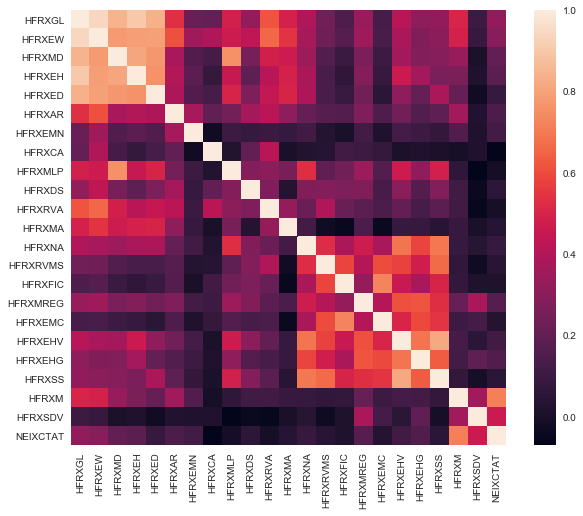

In [30]:
l = []
for cluster in c_net.clusters: 
    l = l + cluster.names
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(C.loc[l,l], ax=ax, square=True)

## Clustering of Risk Premia strategies

In [31]:
C = np.log(1 + risk_premia.pct_change()).corr(method='pearson')
C.head()

,BNPIDRXA,BNPIF3AX,BNPIF3XM,BPFXSTGU,BNPICCE3,BNPIVMRU,BPCURVW4,BNPIVCXA,BNPIAIRT,BPFXGGUR,...,BNPIPMEE,BNPIPQEE,BNPIPVEE,BNPILUEE,BNPIPMUH,BNPIPQUH,BNPIPVUH,BNPIMDEA,BNPIAIFH,BNPICVXA
BNPIDRXA,1.000000,0.424088,0.307608,-0.000386,0.071005,-0.145157,0.086416,-0.013167,-0.076615,-0.093318,...,0.000168,0.001555,-0.082180,0.030302,-0.031722,-0.062680,-0.095039,0.062213,-0.020197,-0.009328
BNPIF3AX,0.424088,1.000000,0.395906,-0.001546,0.041563,-0.080985,0.034940,0.005715,0.007139,-0.008201,...,-0.016434,0.002724,-0.060266,0.019901,0.054450,-0.033962,-0.062446,0.114965,-0.045468,0.008542
BNPIF3XM,0.307608,0.395906,1.000000,-0.000769,-0.014921,-0.157603,0.070217,-0.058121,-0.031500,-0.057323,...,-0.011172,-0.005380,-0.051719,-0.027244,0.017084,-0.034398,-0.055467,0.090041,-0.015139,-0.058192
BPFXSTGU,-0.000386,-0.001546,-0.000769,1.000000,0.015890,-0.016083,-0.051222,-0.019111,0.014179,0.082885,...,0.015481,0.012467,0.015642,0.031212,0.025738,0.000565,-0.017860,-0.038505,-0.025735,-0.027789
BNPICCE3,0.071005,0.041563,-0.014921,0.015890,1.000000,0.062447,-0.011890,0.129057,0.168523,0.021286,...,0.103754,0.043428,0.044734,0.145531,0.062885,-0.020644,-0.070122,0.149605,0.220366,0.133822


In [32]:
%%time
names = list(C.columns)
c_net = cluster_net(names, C)
n = len(names)
c_net.successive_merge(n-1, only_likelihood_improve=True)

Total number of merges: 18
Wall time: 3.73 s


In [33]:
i = 1
for cluster in c_net.clusters:
    print("Cluster",i,": \n", "Average correlation of {:.0%}".format(cluster.average_correl()), "\n",
          df_info.loc[cluster.names], "\n \n")
    i = i + 1

Cluster 1 : 
 Average correlation of 99% 
          Asset Class       Style
Ticker                          
BNPIVCXA   Commodity  Volatility
BNPICVXA   Commodity  Volatility 
 

Cluster 2 : 
 Average correlation of 72% 
          Asset Class       Style
Ticker                          
BNPIAIRG      Equity  Volatility
BNPIAIRE      Equity  Volatility 
 

Cluster 3 : 
 Average correlation of 52% 
          Asset Class  Style
Ticker                     
BNPIEC03      Equity  Carry
BNPICCE3      Equity  Carry 
 

Cluster 4 : 
 Average correlation of 55% 
          Asset Class           Style
Ticker                              
BNPIPQEE      Equity         Quality
BNPIPVEE      Equity           Value
BNPIPMEE      Equity        Momentum
BNPIPLEE      Equity  Low Volatility 
 

Cluster 5 : 
 Average correlation of 38% 
          Asset Class     Style
Ticker                        
BNPIF3AX   Commodity     Carry
BNPIF3XM   Commodity  Momentum
BNPIDRXA   Commodity     Carry 
 

Cluster 6 : 

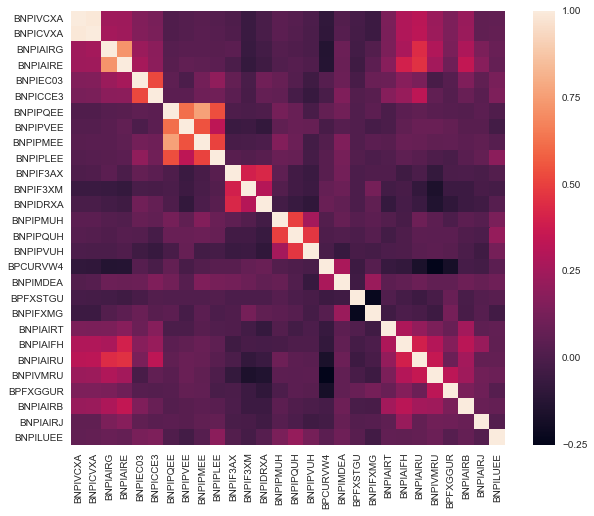

In [34]:
l = []
for cluster in c_net.clusters: 
    l = l + cluster.names
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(C.loc[l,l], ax=ax, square=True)

## Clustering of Classic strategies

In [35]:
C = np.log(1 + bnp.pct_change()).corr(method='pearson')
C.head()

,BNPIFEU,BNPIFUS,BNPIFJP,BNPIFCN,BNPIFFR,BNPIFGE,BNPIFGB,BNPIFCH,BNPIFKR,BNPIFUSC,...,SPGSICP,SPGSIZP,SPGSIKP,SPGSILP,SPGSGCP,SPGSSIP,BNPXCEB5,BNPXCEX5,BNPXCIG5,BNPXCHY5
BNPIFEU,1.000000,0.604836,0.337931,0.382625,0.973898,0.946955,0.883323,0.816829,0.343135,0.539001,...,0.475547,0.366036,0.346358,0.371067,0.006740,0.190864,0.719617,0.748831,0.620318,0.602834
BNPIFUS,0.604836,1.000000,0.146902,0.242353,0.588888,0.606366,0.586966,0.529410,0.228202,0.921373,...,0.340723,0.253225,0.256946,0.273062,0.002861,0.141047,0.481107,0.492803,0.433523,0.564009
BNPIFJP,0.337931,0.146902,1.000000,0.565116,0.350491,0.327024,0.360581,0.362247,0.610017,0.101327,...,0.207894,0.166480,0.140835,0.187817,0.004478,0.116067,0.293686,0.317802,0.359806,0.301839
BNPIFCN,0.382625,0.242353,0.565116,1.000000,0.393350,0.385979,0.416757,0.370690,0.657985,0.187803,...,0.280318,0.236613,0.186372,0.270853,0.046128,0.171834,0.363250,0.380456,0.362900,0.344967
BNPIFFR,0.973898,0.588888,0.350491,0.393350,1.000000,0.931052,0.893785,0.823064,0.353168,0.526276,...,0.475592,0.376807,0.349590,0.373081,0.007263,0.194209,0.708005,0.743141,0.613248,0.603905


In [36]:
%%time
names = list(C.columns)
c_net = cluster_net(names, C)
n = len(names)
c_net.successive_merge(n-1, only_likelihood_improve=True)

Total number of merges: 57
Wall time: 1min 20s


In [37]:
i = 1
for cluster in c_net.clusters:
    print("Cluster",i,": \n", "Average correlation of {:.0%}".format(cluster.average_correl()), "\n",
          df_info.loc[cluster.names], "\n \n")
    i = i + 1

Cluster 1 : 
 Average correlation of 97% 
         Asset Class    Style
Ticker                      
BNPIFJT      Equity  Classic
BNPIFJP      Equity  Classic 
 

Cluster 2 : 
 Average correlation of 95% 
         Asset Class    Style
Ticker                      
BNPIFCN      Equity  Classic
BNPIFHK      Equity  Classic 
 

Cluster 3 : 
 Average correlation of 89% 
          Asset Class    Style
Ticker                       
BNPIFU10       Bonds  Classic
BNPIFU30       Bonds  Classic 
 

Cluster 4 : 
 Average correlation of 88% 
          Asset Class    Style
Ticker                       
BNPIFAU3       Bonds  Classic
BNPIFA10       Bonds  Classic 
 

Cluster 5 : 
 Average correlation of 90% 
         Asset Class    Style
Ticker                      
SPGSHOP   Commodity  Classic
SPGSHUP   Commodity  Classic
SPGSCLP   Commodity  Classic
SPGSBRP   Commodity  Classic 
 

Cluster 6 : 
 Average correlation of 83% 
          Asset Class    Style
Ticker                       
BNPIFUS2       B

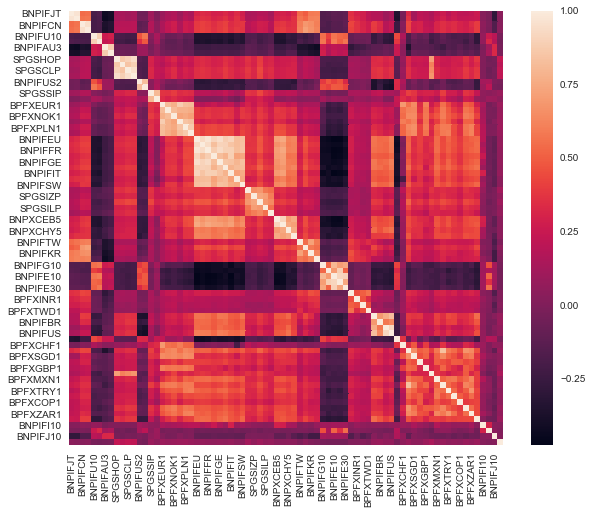

In [38]:
l = []
for cluster in c_net.clusters: 
    l = l + cluster.names
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(C.loc[l,l], ax=ax, square=True)

## Clustering of all BNP strategies

In [39]:
C = np.log(1 + bnp.join(risk_premia, how='inner').pct_change()).corr(method='pearson')
C.head()

,BNPIFEU,BNPIFUS,BNPIFJP,BNPIFCN,BNPIFFR,BNPIFGE,BNPIFGB,BNPIFCH,BNPIFKR,BNPIFUSC,...,BNPIPMEE,BNPIPQEE,BNPIPVEE,BNPILUEE,BNPIPMUH,BNPIPQUH,BNPIPVUH,BNPIMDEA,BNPIAIFH,BNPICVXA
BNPIFEU,1.000000,0.618777,0.354709,0.394407,0.973791,0.946331,0.886743,0.816149,0.358946,0.551058,...,-0.145659,-0.172184,-0.083923,0.060554,-0.028689,-0.002609,0.022716,0.029350,0.273600,0.219266
BNPIFUS,0.618777,1.000000,0.156394,0.243176,0.602214,0.617710,0.605890,0.544830,0.233399,0.921396,...,0.023624,-0.013481,0.060396,0.108535,0.039615,0.034837,0.017165,0.136395,0.243210,0.189495
BNPIFJP,0.354709,0.156394,1.000000,0.574233,0.365985,0.342699,0.377323,0.378453,0.614118,0.110258,...,0.010011,0.005989,0.061817,0.001228,-0.043010,-0.023313,0.016665,0.081525,0.158187,0.161622
BNPIFCN,0.394407,0.243176,0.574233,1.000000,0.402387,0.398446,0.429392,0.378947,0.667219,0.189062,...,0.064260,0.042182,0.086445,-0.029878,0.000534,-0.006006,0.010120,0.075225,0.170987,0.187890
BNPIFFR,0.973791,0.602214,0.365985,0.402387,1.000000,0.930297,0.897672,0.822564,0.367419,0.538009,...,-0.091760,-0.116235,-0.021823,0.054609,-0.024981,0.001719,0.024917,0.036810,0.275106,0.224117


In [40]:
%%time
names = list(C.columns)
c_net = cluster_net(names, C)
n = len(names)
c_net.successive_merge(n-1, only_likelihood_improve=True)

Total number of merges: 75
Wall time: 3min 33s


In [41]:
i = 1
for cluster in c_net.clusters:
    print("Cluster",i,": \n", "Average correlation of {:.0%}".format(cluster.average_correl()), "\n",
          df_info.loc[cluster.names], "\n \n")
    i = i + 1

Cluster 1 : 
 Average correlation of 99% 
          Asset Class       Style
Ticker                          
BNPIVCXA   Commodity  Volatility
BNPICVXA   Commodity  Volatility 
 

Cluster 2 : 
 Average correlation of 97% 
         Asset Class    Style
Ticker                      
BNPIFJT      Equity  Classic
BNPIFJP      Equity  Classic 
 

Cluster 3 : 
 Average correlation of 95% 
         Asset Class    Style
Ticker                      
BNPIFCN      Equity  Classic
BNPIFHK      Equity  Classic 
 

Cluster 4 : 
 Average correlation of 89% 
          Asset Class    Style
Ticker                       
BNPIFU10       Bonds  Classic
BNPIFU30       Bonds  Classic 
 

Cluster 5 : 
 Average correlation of 87% 
          Asset Class    Style
Ticker                       
BNPIFAU3       Bonds  Classic
BNPIFA10       Bonds  Classic 
 

Cluster 6 : 
 Average correlation of 90% 
         Asset Class    Style
Ticker                      
SPGSHOP   Commodity  Classic
SPGSHUP   Commodity  Classic
SP

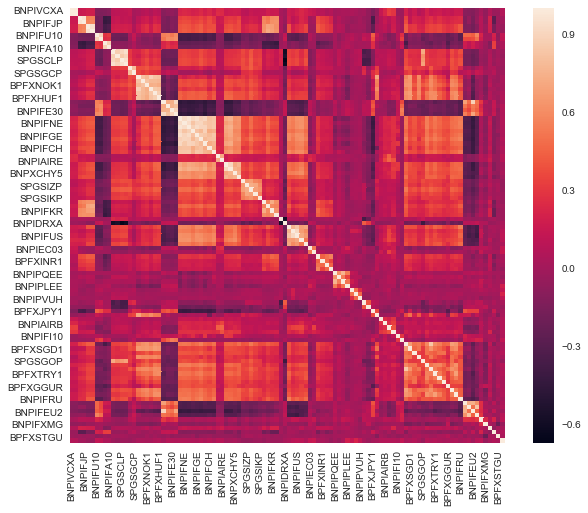

In [42]:
l = []
for cluster in c_net.clusters: 
    l = l + cluster.names
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(C.loc[l,l], ax=ax, square=True)